In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel("../data/raw/Online_Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Minimal Cleaning (Retention-safe)

df = df.dropna(subset=['CustomerID'])
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [4]:
# Create Cohort Month

df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

df['CohortMonth'] = (
    df.groupby('CustomerID')['InvoiceDate']
      .transform('min')
      .dt.to_period('M')
)

df[['CustomerID', 'InvoiceMonth', 'CohortMonth']].head()

,CustomerID,InvoiceMonth,CohortMonth
0,17850.0,2010-12,2010-12
1,17850.0,2010-12,2010-12
2,17850.0,2010-12,2010-12
3,17850.0,2010-12,2010-12
4,17850.0,2010-12,2010-12


In [5]:
# Cohort Index

def get_month_diff(df, col1, col2):
    return (df[col1].dt.year - df[col2].dt.year) * 12 + (df[col1].dt.month - df[col2].dt.month)

df['CohortIndex'] = get_month_diff(df, 'InvoiceMonth', 'CohortMonth') + 1

In [6]:
# Cohort Table

cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'] \
                .nunique().reset_index()

cohort_table = cohort_data.pivot(
    index='CohortMonth',
    columns='CohortIndex',
    values='CustomerID'
)

cohort_table

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Retention Matrix (%)

cohort_size = cohort_table.iloc[:,0]
retention = cohort_table.divide(cohort_size, axis=0)

retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,1.0,0.366102,0.323164,0.384181,0.362712,0.397740,0.362712,0.349153,0.353672,0.395480,0.374011,0.502825,0.265537
2011-01,1.0,0.220624,0.266187,0.230216,0.321343,0.287770,0.247002,0.242206,0.299760,0.326139,0.364508,0.117506,NaN
2011-02,1.0,0.186842,0.186842,0.284211,0.271053,0.247368,0.252632,0.278947,0.247368,0.305263,0.068421,NaN,NaN
2011-03,1.0,0.150442,0.252212,0.199115,0.223451,0.168142,0.267699,0.230088,0.278761,0.086283,NaN,NaN,NaN
2011-04,1.0,0.213333,0.203333,0.210000,0.196667,0.226667,0.216667,0.260000,0.073333,NaN,NaN,NaN,NaN
2011-05,1.0,0.190141,0.172535,0.172535,0.207746,0.232394,0.264085,0.095070,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.173554,0.157025,0.264463,0.231405,0.334711,0.095041,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.180851,0.207447,0.223404,0.271277,0.111702,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.207101,0.248521,0.242604,0.124260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


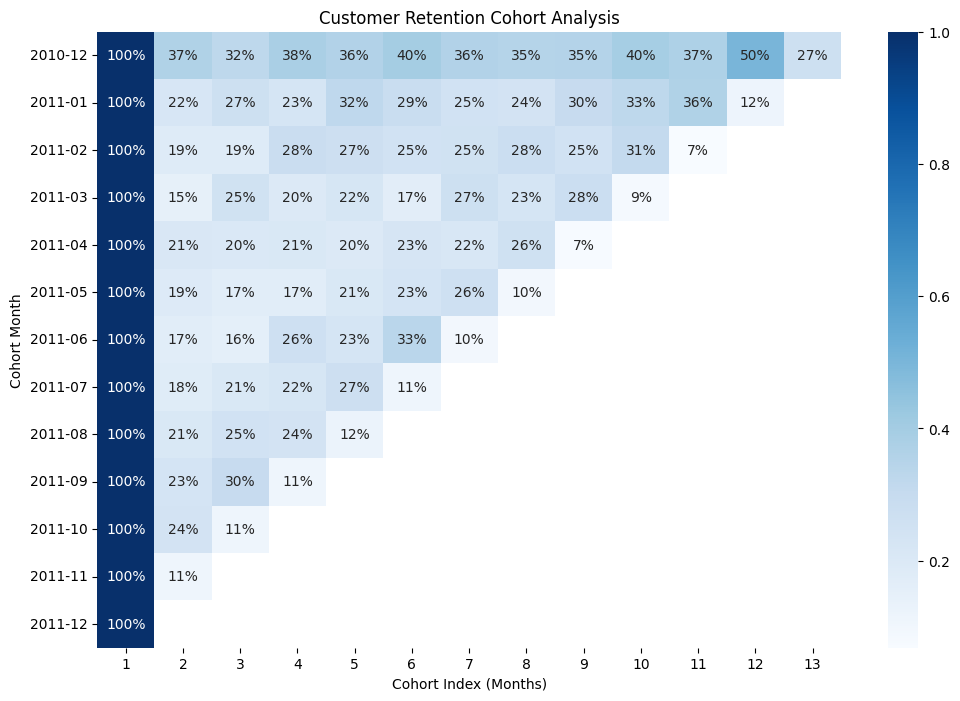

In [8]:
# Retention Heatmap

plt.figure(figsize=(12,8))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="Blues")
plt.title("Customer Retention Cohort Analysis")
plt.xlabel("Cohort Index (Months)")
plt.ylabel("Cohort Month")
plt.show()